# Project 3: Web APIs & Classification
____________

# Part 2 - Modelling, Evaluation, Conclusions

### Riche Ngo, SG-DSI-18

## Problem Statement

To keep up with current trends, companies, especially start-ups, are more willing to employ digital nomads to be part of their workforce. However, organisations are also worried about the mental stability of their potential employees and the risk of poor work quality. As part of the data scientist team in a recruitment agency, we want to understand the demographic of digital nomads and whether there is truly a correlation between the nomadic lifestyle and people who do not have relationship. We want to develop a classification model that could identify traits between digital nomads and people who are not in a relationship using Natural Language Processing. Essentially, what we want to know is, are freedom and love mutually exclusive?

## Executive Summary

This project explores data collected from two subreddits using Reddit's API, namely '[digitalnomad](https://www.reddit.com/r/digitalnomad/)' and '[marriagefree](https://www.reddit.com/r/marriagefree/)'. We focus on analyzing the textual content posted by each Reddit user, together with the titles of the posts, using Natural Language Processing techniques.

The data was found to be relatively clean since the Reddit platform enables us to scrape the data in a *.json* format. However, since we are extracting only the title and main content of each post, we had to drop many duplicates which resulted in an imbalanced number of posts between the two subreddits. The average length of posts for each subreddit was quite similar, about 115-131 words. 

Preprocessing was done by removing common stopwords within the `nltk` library and the remaining words were lemmatized. Looking at the top frequently occurring words in each subreddit, we found that people in 'digitalnomad' were often discussing about work and travel while people in 'marriagefree' were often discussing about relationships and life.

While developing the classifier model, we built several pipelines, each containing a vectorizer and a classification model. We tuned the models' hyperparameters to obtain the best cross-validated score for each pipeline. Comparing the cross-validated scores, which give an estimate of the model's accuracy on unseen data, the best model was found to be a Multinomial Naive Bayes model. Since the hold-out method was also adopted, we could compare acuracy scores between train and test(hold-out) data, which were 0.98 and 0.97 respectively. Although it indicated slight overfitting of the data, the small difference was acceptable by our means. The high accuracy scores also suggest that digital nomads and single/unmarried people are very distinguishable.

The prominent words which the Naive Bayes model used to classify the textual data into 'digitalnomad' posts are words relating to travel, countries, and accomodation while posts with words relating to relationships, family, and disharmony. Incidentally, the posts that the model misclassified under the 'digitalnomad' subreddit have words that are more related to finance while posts that are misclassified under the 'marriagefree' subreddit have words relating to family or females. We also observed that words like 'depressing' appeared over more than one post that were misclassified under the 'digitalnomal' subreddit. This may suggest some sort of correlation between distress and digital nomadism.

### Contents:
- [Modelling & Hyperparameter Tuning](#Modelling-&-Hyperparameter-Tuning)
- [Model Selection & Evaluation](#Model-Selection-&-Evaluation)
- [Further Exploration](#Further-Exploration)
- [Conclusions](#Conclusions)

In [75]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Import Data

We will import the preprocessed datasets to be used for model development.

In [3]:
file_1 = '../datasets/digitalnomad_preprocessed.csv'
file_2 = '../datasets/marriagefree_preprocessed.csv'

In [4]:
df_1 = pd.read_csv(file_1)
df_2 = pd.read_csv(file_2)

In [5]:
df_1.head()

,posts
0,esl training selling business going hunker mon...
1,work income group list comment income get feel...
2,waiting pandemic home country going travel soo...
3,designremotely world resource remote designer ...
4,covid affected safety crime medellin colombia ...


In [6]:
df_1.shape

(2464, 1)

In [7]:
df_2.head()

,posts
0,true crime partly influenced decision pretty a...
1,kid get long time always knew wanna get cause ...
2,gf broke cuz breaking heart girlfriend year br...
3,life hack
4,oscar wilde quote


In [8]:
df_2.shape

(429, 1)

## Data Preparation

In [9]:
# Check for null values
print('Null values in df_1:\n', df_1.isnull().sum())
print()
print('Null values in df_2:\n', df_2.isnull().sum())

Null values in df_1:
 posts    4
dtype: int64

Null values in df_2:
 posts    0
dtype: int64


There is a null value in df_1 which is probably due to the post being all stopwords and was replaced by a blank. We will need to drop this row.

In [10]:
# Dropping null
df_1.dropna(inplace=True)

In [11]:
# Set binary variables to indicate the origin of each post
# 0 would indicate post originated from subreddit 1
# 1 would indicate post orginated from subreddit 2
df_1['origin_marriagefree'] = 0
df_2['origin_marriagefree'] = 1

In [12]:
# Concatenate the two dataframes
combined_df = pd.concat([df_1, df_2]).reset_index(drop=True)
combined_df.shape

(2889, 2)

In [13]:
combined_df.head()

,posts,origin_marriagefree
0,esl training selling business going hunker mon...,0
1,work income group list comment income get feel...,0
2,waiting pandemic home country going travel soo...,0
3,designremotely world resource remote designer ...,0
4,covid affected safety crime medellin colombia ...,0


In [14]:
combined_df.tail()

,posts,origin_marriagefree
2884,okay okay,1
2885,socioeconomic question always loathed concept ...,1
2886,finally awesome proud spinster nine year hard ...,1
2887,love emma goldman,1
2888,fleeing forced,1


In [15]:
# Setting the variables
X = combined_df['posts']
y = combined_df['origin_marriagefree']

In [16]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 50)

In [17]:
X_train.shape

(2166,)

In [18]:
X_test.shape

(723,)

## Modelling & Hyperparameter Tuning  

We want to fit all the models using `GridSearchCV` so that each model will be optimized. We will select the best model based on the cross-validated scores.  

### Baseline Prediction

In [19]:
# Look at the proportions of each outcome
y.value_counts(normalize=True)

0    0.851506
1    0.148494
Name: origin_marriagefree, dtype: float64

If we were to predict all values to be class 0 (dominant class), originated from subreddit 1 in this case, we would have correctly predicted 85% of the values.

### Type of Vectorizer  

Using the basic classification models such as `LogisticRegression` and `MultinomialNB`, we want to determine which vectorizer will give us better performance, then further expand on the model types using the chosen vectorizer.

In [20]:
# Basic pipelines for each vectorizer
pipe_lr_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())  
])

pipe_lr_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())  
])

pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())  
])

pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())  
])

In [21]:
# Fitting all the models
pipe_lr_cvec.fit(X_train, y_train)
pipe_lr_tvec.fit(X_train, y_train)
pipe_nb_cvec.fit(X_train, y_train)
pipe_nb_tvec.fit(X_train, y_train);

In [22]:
pipe_lr_cvec.steps[0]

('cvec', CountVectorizer())

In [23]:
# Compare scores for each model
for model in [pipe_lr_cvec, pipe_lr_tvec, pipe_nb_cvec, pipe_nb_tvec]:
    print(f'Score for {str(model.steps[1][0])}_{str(model.steps[0][0])}:')
    print(cross_val_score(model, X_train, y_train, cv=5).mean())
    print('-----------------')

Score for lr_cvec:
0.9321378018539607
-----------------
Score for lr_tvec:
0.8988984791562457
-----------------
Score for nb_cvec:
0.956607528655506
-----------------
Score for nb_tvec:
0.8518012792541587
-----------------


**Observations:**  
We observed that `CountVectorizer` performed better for both Logistic Regression and Naive Bayes. We will further expand the types of models using `CountVectorizer` and also tune its hyperparameters.

### Fitting Logistic Regression

In [24]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())  
])

In [25]:
# Search over the following values of hyperparameters:

pipe_lr_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [0.7, 0.8],
    'cvec__ngram_range': [(1,1), (1,2)],  
    'lr__C': [1, 0.1],
    'lr__solver': ['newton-cg', 'lbfgs'],
    'lr__class_weight': ['balanced', None]
}

In [26]:
# Instantiate GridSearchCV.
# 5-fold
gs_lr = GridSearchCV(pipe_lr, param_grid = pipe_lr_params, cv=5,
                     verbose=1)
# Fit GridSearch to training data.
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  5.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.7, 0.8],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [4, 5, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'lr__C': [1, 0.1],
                         'lr__class_weight': ['balanced', None],
                         'lr__solver': ['newton-cg', 'lbfgs']},
             verbose=1)

In [27]:
gs_lr.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 3000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 1),
 'lr__C': 1,
 'lr__class_weight': None,
 'lr__solver': 'newton-cg'}

In [28]:
gs_lr.best_score_

0.9381402922489117

In [29]:
# Initialize empty list to store all the scores and corresponding model names
model_name = []
model_scores = []
model_var = []

# Append to the lists
model_name.append('Logistic Regression')
model_scores.append(gs_lr.best_score_)
model_var.append(gs_lr)

### Fitting Naive Bayes  

We will use `MultinomialNB` since the features have discrete number of outcomes and it works well with the `CountVectorizer` transformer that we are adopting.

Naive Bayes classification assumes that the features are independent of one another.

In [30]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. MultinomialNB (estimator)
pipe_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())  
])

In [31]:
# Search over the following values of hyperparameters:

pipe_nb_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [0.7, 0.8],
    'cvec__ngram_range': [(1,1), (1,2)],  
    'nb__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
}

In [32]:
# Instantiate GridSearchCV.
# 5-fold
gs_nb = GridSearchCV(pipe_nb, param_grid = pipe_nb_params, cv=5,
                     verbose=1)
# Fit GridSearch to training data.
gs_nb.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  4.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.7, 0.8],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [4, 5, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'nb__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1]},
             verbose=1)

In [33]:
gs_nb.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 3000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.1}

In [34]:
gs_nb.best_score_

0.9626089547791106

In [35]:
# Append to the lists
model_name.append('Naive Bayes')
model_scores.append(gs_nb.best_score_)
model_var.append(gs_nb)

### Fitting Random Forest  

We will be using `RandomForestClassifier` and forgo the creation of model using `DecisionTreeClassifier` or `BaggingClassifier` because RandomForest tend to perform better than the other two in terms of accuracy.

In [36]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. RandomForestClassifier (estimator)
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=50))  
])

In [37]:
# Search over the following values of hyperparameters:

pipe_rf_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [0.7, 0.8],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [80, 100],
    'rf__max_depth': [3, 5],
    'rf__min_samples_leaf': [2, 4]
}

In [38]:
# Instantiate GridSearchCV.
# 5-fold
gs_rf = GridSearchCV(pipe_rf, param_grid = pipe_rf_params, cv=5,
                     verbose=1)
# Fit GridSearch to training data.
gs_rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  7.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=50))]),
             param_grid={'cvec__max_df': [0.7, 0.8],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [4, 5, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'rf__max_depth': [3, 5],
                         'rf__min_samples_leaf': [2, 4],
                         'rf__n_estimators': [80, 100]},
             verbose=1)

In [39]:
gs_rf.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 3000,
 'cvec__min_df': 6,
 'cvec__ngram_range': (1, 2),
 'rf__max_depth': 5,
 'rf__min_samples_leaf': 2,
 'rf__n_estimators': 80}

In [40]:
gs_rf.best_score_

0.8601111099285873

In [41]:
# Append to the lists
model_name.append('Random Forest')
model_scores.append(gs_rf.best_score_)
model_var.append(gs_rf)

### Fitting Boosted Trees  

In [42]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. AdaBoost (estimator)
pipe_ada = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(random_state=50))  
])

In [43]:
# Search over the following values of hyperparameters:

pipe_ada_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [0.7, 0.8],
    'cvec__ngram_range': [(1,1), (1,2)],
    'ada__n_estimators': [30, 40, 50],
    'ada__learning_rate': [0.8, 0.9, 1]
}

In [44]:
# Instantiate GridSearchCV.
# 5-fold
gs_ada = GridSearchCV(pipe_ada, param_grid = pipe_ada_params, cv=5,
                     verbose=1)
# Fit GridSearch to training data.
gs_ada.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  9.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(random_state=50))]),
             param_grid={'ada__learning_rate': [0.8, 0.9, 1],
                         'ada__n_estimators': [30, 40, 50],
                         'cvec__max_df': [0.7, 0.8],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [4, 5, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [45]:
gs_ada.best_params_

{'ada__learning_rate': 0.9,
 'ada__n_estimators': 30,
 'cvec__max_df': 0.7,
 'cvec__max_features': 2500,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 1)}

In [46]:
gs_ada.best_score_

0.9275177999382723

In [47]:
# Append to the lists
model_name.append('AdaBoost')
model_scores.append(gs_ada.best_score_)
model_var.append(gs_ada)

### Fitting Support Vector Classifier 

In [48]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. SVC (estimator)
pipe_svc = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())  
])

In [49]:
# Search over the following values of hyperparameters:

pipe_svc_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [0.7, 0.8],
    'cvec__ngram_range': [(1,1), (1,2)],  
    'svc__C': [1, 0.1],
    'svc__kernel': ['rbf', 'poly'],
    'svc__degree': [2, 3]
}

In [50]:
# Instantiate GridSearchCV.
# 5-fold
gs_svc = GridSearchCV(pipe_svc, param_grid = pipe_svc_params, cv=5,
                     verbose=1)
# Fit GridSearch to training data.
gs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 15.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'cvec__max_df': [0.7, 0.8],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [4, 5, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'svc__C': [1, 0.1], 'svc__degree': [2, 3],
                         'svc__kernel': ['rbf', 'poly']},
             verbose=1)

In [51]:
gs_svc.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 2500,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'svc__C': 1,
 'svc__degree': 2,
 'svc__kernel': 'rbf'}

In [52]:
gs_svc.best_score_

0.902128542693245

In [53]:
# Append to the lists
model_name.append('Support Vector Classifier')
model_scores.append(gs_svc.best_score_)
model_var.append(gs_svc)

## Model Selection & Evaluation

In [80]:
# View the evaluation metrics for all models in a dataframe
# Sorted by highest accuracy
precision_list = []
recall_list = []
fscore_list = []
for model in model_var:
    y_pred = model.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

pd.DataFrame({'Model Type': model_name,
             'CV Score': model_scores,
             'Precision': precision_list,
             'Recall': recall_list,
             'F1-Score': fscore_list}).sort_values(by='CV Score', ascending=False)

,Model Type,CV Score,Precision,Recall,F1-Score
1,Naive Bayes,0.962609,0.956293,0.920364,0.937222
0,Logistic Regression,0.938140,0.944468,0.823856,0.870535
3,AdaBoost,0.927518,0.936613,0.791146,0.843201
4,Support Vector Classifier,0.902129,0.950292,0.682243,0.740969
2,Random Forest,0.860111,0.930168,0.532710,0.523866


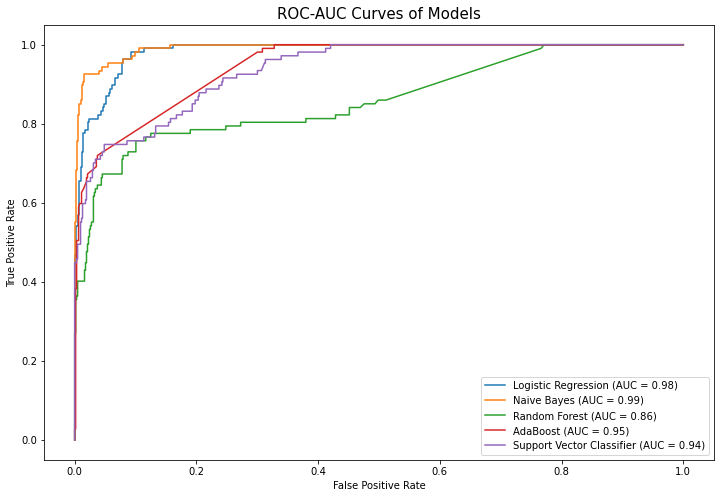

In [55]:
# Plotting the ROC curves for every model
plt.figure(figsize=(12,8))
ax = plt.gca()
for model, m_name in zip(model_var, model_name):
    plot_roc_curve(model, X_test, y_test, name=m_name, ax=ax)
plt.title('ROC-AUC Curves of Models', fontsize=15);

In [56]:
# Function to plot multiple confusion matrix
def subplot_confusion_matrix(model_list, model_name, X_test, y_test):
    nrows = int(np.ceil(len(model_list)/3))   # Ensure have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows*4))   
    plt.subplots_adjust(hspace = 0.4)
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, model in enumerate(model_list):   # Gives us an index value to get into all our lists
        plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d', ax=ax[i])
        ax[i].set_title(model_name[i])
    
        # display scale and label only on the left edge
        if i%3 != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels('')
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(model_list):]:
        axes.axis('off')
    fig.tight_layout()
    pass

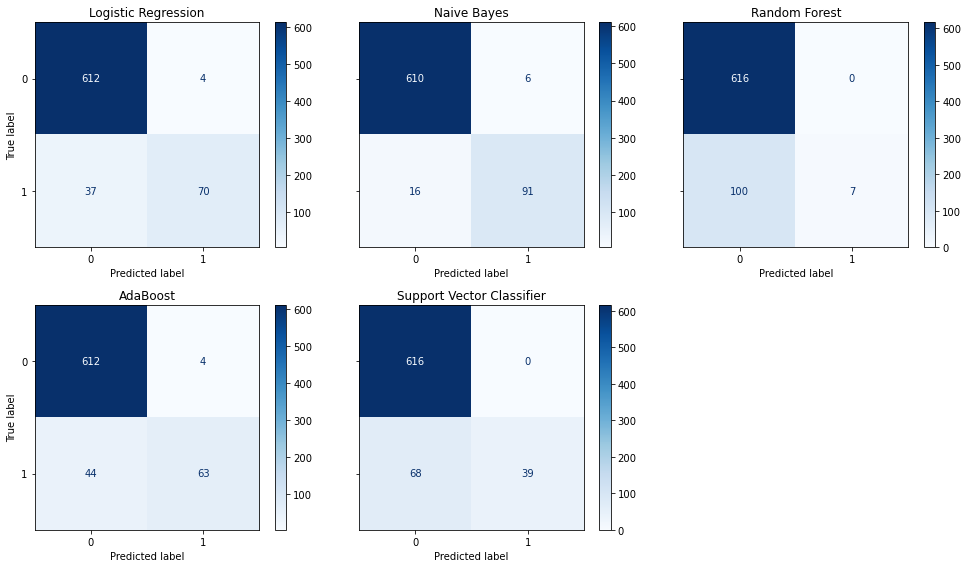

In [57]:
# Plotting confusion matrix for all models
subplot_confusion_matrix(model_var, model_name, X_test, y_test)

**Observations:**  
From the above, we are able to observe the following things:  
1. **Cross-validated score** - The CV scores of all the tuned models using `GridSearchCV`. This simulates the estimated accuracy of each model on unseen data. Ideally, we want to pick the model with the highest CV score (closest to 1.0).
2. **Precision** - The precision is the ability of the classifier to not label a negative sample as positive. The higher the precision, the better the classifier model is at positive samples correctly.
3. **Recall** - The recall is the ability of the classifier to find all the positive samples. The higher the recall, the higher the proportion of correctly predicted positive samples.
4. **F1-Score** - The F1 score is the weighted average of the precision and recall, where it reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The higher the F1 score, the better the classifier is.
5. **ROC-AUC curve** - The ROC-AUC curves of all the tuned models. We can observe the relationship between the True Positive Rate (a.k.a. sensitivity or recall) and the False Positive Rate (a.k.a. specificity). Ideally, we want to pick the model with the highest ROC AUC (closest to 1.0), where the positive and negative classes are most separated.
6. **Confusion matrix** - The confusion matrix of all the tuned models, where we can observe the number of True/False Positives and True/False Negatives. In this case, we want to choose a model where it can best reduce the total number of incorrect predictions, in other words the least number of False Positives and False Negatives.

By observing the above, we see that all of the models performed better than the baseline prediction. Of which, the model best optimized on the various scoring metrics is the **Naive Bayes model**.

#### Naive Bayes Summary

This classifier works on the principle of conditional probability, as given by the Bayes theorem. For each token, it calculates the conditional probability of that token given each class. This is done for every token and both classes to make a prediction. It assumes that the features are independent of one another.

Advantages of Naive Bayes include:
- It is simple and easy to implement.
- It doesn’t require as much training data.
- It is highly scalable with the number of predictors and data points. This means that it works well in cases such as text classification.
- It is not sensitive to irrelevant features.

Caveats of Naive Bayes include:  
- In real life, it is almost impossible to find a set of predictors which are completely independent. This would violate the assumption of feature independency.
- It would not be able to make a prediction on unseen data that if a categorical variable has a category in test data set, which was not observed in training data set. This is often known as Zero Frequency. In spite of that, this issue could be solved by using smoothing techniques such as Laplace estimation.

### Hyperparameters Extraction

We want to extract the hyperparameters selected by `GridSearchCV` for the selected model and re-fit the model to be used for validation. The reason for doing this is because the cross-validation trained the model using 4 out of 5 folds of data, we want to train the model again using the full training dataset.

In [58]:
# Hyperparameters for the selected model
gs_nb.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 3000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.1}

In [59]:
# Setting up the pipeline
best_model = Pipeline([
    ('cvec', CountVectorizer(max_df=0.7,
                            max_features=3000,
                            min_df=4,
                            ngram_range=(1,1))),
    ('nb', MultinomialNB(alpha=0.1))  
])

# Fitting the model
best_model.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.7, max_features=3000, min_df=4)),
                ('nb', MultinomialNB(alpha=0.1))])

### Validation

In [60]:
# Scoring the model on train and test data
print('Accuracy score on training data:')
print(best_model.score(X_train, y_train))
print('------------------------')
print('Accuracy score on testing data:')
print(best_model.score(X_test, y_test))

Accuracy score on training data:
0.9792243767313019
------------------------
Accuracy score on testing data:
0.9695712309820194


We observe that the accuracy score on the training data is slightly higher than that of the testing data which indicates that the model is slightly overfitted but only to a small extent.

The high accuracy score tells us that the model had very effective means of distinguishing between the two subreddits, which suggests that digital nomads and single/unmarried people talk about very different things.

## Further Exploration  

We want to explore the classification model further and its performance on the data.

### Word Importance  

We want to understand which words influence the classification of each class the most.

In [61]:
# Naive Bayes counts the number of times each token appears in each class
# trailing underscore - learned during fitting
nb = best_model.steps[1][1]
nb.feature_count_

array([[ 19., 173.,  94., ...,  28.,  20.,   9.],
       [  3.,  14.,   0., ...,   3.,   0.,   0.]])

Each row in the above array represents the class, and each column represents the count of the token appearing given that class.

In [62]:
# number of times each token appears across all subreddit 1 posts
sr1_token_count = nb.feature_count_[0, :]
sr1_token_count

array([ 19., 173.,  94., ...,  28.,  20.,   9.])

In [63]:
# number of times each token appears across all subreddit 2 posts
sr2_token_count = nb.feature_count_[1, :]
sr2_token_count

array([ 3., 14.,  0., ...,  3.,  0.,  0.])

In [64]:
# create a DataFrame of tokens with their separate ham and spam counts
vect = best_model.steps[0][1]
X_train_tokens = vect.get_feature_names()
tokens = pd.DataFrame({'token':X_train_tokens, 'digitalnomad':sr1_token_count, 'marriagefree':sr2_token_count}).set_index('token')
tokens.head()

,digitalnomad,marriagefree
token,,
ability,19.0,3.0
able,173.0,14.0
abroad,94.0,0.0
absolute,11.0,1.0
absolutely,22.0,6.0


In [65]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([1844.,  322.])

In [66]:
# Convert the token counts into frequencies
# we add a value of 1 first to prevent divide by zero error
tokens['digitalnomad'] = (tokens['digitalnomad'] + 1) / nb.class_count_[0]
tokens['marriagefree'] = (tokens['marriagefree'] + 1) / nb.class_count_[1]

# Calculate the ratio of subreddit 1-to-subreddit 2 for each token
tokens['ratio'] = tokens['digitalnomad'] / tokens['marriagefree']

tokens.tail()

,digitalnomad,marriagefree,ratio
token,,,
zanzibar,0.003796,0.003106,1.222343
zealand,0.008677,0.003106,2.793926
zero,0.015727,0.012422,1.265998
zone,0.011388,0.003106,3.667028
zoom,0.005423,0.003106,1.746204


In [67]:
# examine the DataFrame sorted by ratio
sorted_tokens = tokens.sort_values('ratio', ascending=False)

# View the top 20 tokens by ratio
sorted_tokens.head(20)

,digitalnomad,marriagefree,ratio
token,,,
remote,0.304230,0.006211,48.981020
dn,0.129610,0.003106,41.734273
remotely,0.110087,0.003106,35.447939
airbnb,0.098698,0.003106,31.780911
free,0.097614,0.003106,31.431670
client,0.092733,0.003106,29.860087
service,0.079718,0.003106,25.669197
product,0.067245,0.003106,21.652928
laptop,0.066161,0.003106,21.303688


The tokens with the highest ratio are the ones which help to classify the posts into Subreddit 1 (digitalnomad). From above, we could tell that the model was classifying 'digitalnomad' posts using words relating to travel, countries, accomodations.

In [68]:
# View the bottom 20 tokens by ratio
sorted_tokens.tail(20)

,digitalnomad,marriagefree,ratio
token,,,
bingo,0.000542,0.021739,0.024946
marrying,0.001085,0.043478,0.024946
pressured,0.000542,0.021739,0.024946
cousin,0.001085,0.052795,0.020544
horror,0.000542,0.027950,0.019402
mf,0.000542,0.027950,0.019402
sexual,0.000542,0.027950,0.019402
celebrate,0.000542,0.027950,0.019402
argument,0.000542,0.031056,0.017462


The tokens with the lowest ratio are the ones which help to classify the posts into Subreddit 2 (marriagefree). From above, we could tell that the model was classifying 'marriagefree' posts using words relating to relationships, family, and disharmony.

### Misclassified Posts  

We want to understand which are the posts which are misclassified.

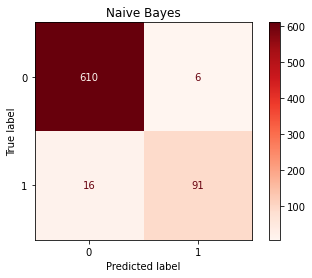

In [69]:
# Taking a look at the confusion matrix again
plot_confusion_matrix(best_model, X_test, y_test, cmap='Reds', values_format='d')
plt.title('Naive Bayes');

In [70]:
# Assign variables
y_pred = best_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [71]:
print(f'Out of {y_test.shape[0]} test values, {(fp + fn)} are predicted incorrectly.')
print(f'Of which, there are {fp} False Positives and {fn} False Negatives.')

Out of 723 test values, 22 are predicted incorrectly.
Of which, there are 6 False Positives and 16 False Negatives.


In [72]:
# Put the true values and predicted values into dataframe
pred_df = y_test.to_frame()
pred_df['predictions'] = y_pred
pred_df.rename(columns={'origin_marriagefree': 'true_values'}, inplace=True)
pred_df.head()

,true_values,predictions
587,0,0
1155,0,0
371,0,0
136,0,0
1896,0,0


In [73]:
# Create function that shows the misclassified posts
# also prints predicted and true values
def print_misclassified(nonvec_X_test, predictions_df, class_names):
    # Extract the indices for the posts that were misclassified
    miscl_idx = pred_df[pred_df['true_values'] != pred_df['predictions']].index
    
    print(f'There are a total of {len(miscl_idx)} misclassified posts.\n\n')
    
    for i in miscl_idx:
        name_1 = class_names[int(predictions_df.loc[i, 'true_values'])]
        classtype_1 = predictions_df.loc[i, 'true_values']
        name_2 = class_names[int(predictions_df.loc[i, 'predictions'])]
        classtype_2 = predictions_df.loc[i, 'predictions']
        print(f'Post no. {i}:')
        print(f"This is a {name_1}(Class {classtype_1}) post, misclassified as a {name_2}(Class {classtype_2}) post\n")
        print(nonvec_X_test[i])
        print('--------------------------------------------------------------------------')

In [74]:
# Print out misclassified posts
print_misclassified(X_test, pred_df, ['digitalnomad', 'marriagefree'])

There are a total of 22 misclassified posts.


Post no. 239:
This is a digitalnomad(Class 0) post, misclassified as a marriagefree(Class 1) post

minimalist parent christmas kid first currently island amazon delivery idea gift decoration tradition idea would appreciated thanks
--------------------------------------------------------------------------
Post no. 2739:
This is a marriagefree(Class 1) post, misclassified as a digitalnomad(Class 0) post

craigslist confessional exactly minute day mine
--------------------------------------------------------------------------
Post no. 2887:
This is a marriagefree(Class 1) post, misclassified as a digitalnomad(Class 0) post

love emma goldman
--------------------------------------------------------------------------
Post no. 2888:
This is a marriagefree(Class 1) post, misclassified as a digitalnomad(Class 0) post

fleeing forced
--------------------------------------------------------------------------
Post no. 2614:
This is a marriagefree(Cla

**Observations:**  
In general, the posts that are misclassified into subreddit 2 (marriagefree) have elements or words relating to family or females (such as 'woman', 'kid', 'child'), and the posts that are misclassified into subreddit 1 (digitalnomad) have elements or words that are more related to finance (such as 'insurance', 'money', 'tax'). It seems like people in the 'digitalnomad' community are more frequently discussing about their financial stability more so than about their families because of their lifestyles.

Posts misclassified under the 'digitalnomad' community tend to have less words as seen above, and most of which seem almost random. Interestingly, there are several occurrences of words like 'depressing' which comes across as a negative emotional feeling more likely to be classified under the 'marriagefree' community as with what the model did. This may suggest that people within the 'digitalnomad' community may also have discussions about the negative emotions which they have while leading their nomadic lifestyles.

## Conclusions

Through this project, we gained many useful insights about the discussions among people within the 'digitalnomad' and 'marriagefree' subreddits. Using the lemmatized textual data scraped from Reddit's API, we were able to develop a Multinomial Naive Bayes model with tuned hyperparameters to classify the users' posts into the two subreddits. In the process of constructing the model, we learnt that digital nomads and single/unmarried people talk about very different things. This may mean that freedom in digital nomadism and love are mutually exclusive and companies looking to recruit digital nomads should not be too worried about the mental instability caused by the loss of a relationship or the lack thereof. Despite that, this project is limited to analyzing data collected from two subreddit communities and it may not be sufficient to make such a bold claim.

The classification model which we developed had a high accuracy score of 0.98, performing much better than the baseline score of 0.85. The model classified data into 'digitalnomad' posts using words relating to travel, countries, and accomodation and classified data into 'marriagefree' posts using words relating to relationships, family, and disharmony. 3% of the test values are predicted incorrectly, which comprises of 6 False Positives and 16 False Negatives (posts originating from the 'marriagefree' subreddit considered as positive class). Posts misclassified under the 'digitalnomad' subreddit have words relating to finance while posts misclassified under the 'marriagefree' subreddit have words relating to family or females.

Further studies could be done if we were to analyze more discussions from other social media platforms such as Twitter, Facebook, Youtube, on digital nomadism. From these discussions we could continue to discover other traits and characteristics about people who decided to live the nomadic lifestyle. It is also possible to develop a survey targeted at digital nomads to obtain more information about their demographics. With deeper understanding, we would be able to provide better professional advice to organizations looking to employ digital nomads, and boosting reputation as a recruitment agency.